In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split

# import MinMax Scaler library
from sklearn.preprocessing import MinMaxScaler

# print versions
print("PyTorch Version: " + torch.__version__)
print("Sklearn Version: " + sklearn.__version__)
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

PyTorch Version: 2.5.1
Sklearn Version: 1.5.2
Numpy Version: 2.1.3
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.11.10


In [2]:
# full dataframe
df = pd.read_pickle("../Data/CleanFullLabelsML.pkl")

# data label
df_label = pd.read_pickle("../Data/colLabelML.pkl") 

# boolean
df_bool = pd.read_pickle("../Data/colBooleanML.pkl")

# nominal
df_nominal = pd.read_pickle("../Data/colNominalML.pkl")

# ordinal
df_ordinal = pd.read_pickle("../Data/colOrdinalML.pkl")

# numeric
df_numeric = pd.read_pickle("../Data/colNumericML.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

### User function(s)

In [3]:
def percentageNull(datadf):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (datadf.count() / len(datadf) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = datadf.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn
    
    
def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)

    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data


def removeHouseKeeping(data, removeColLst, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataLabel = removeRowUsingMask(dataLabel, removeColLst, colstr='label')
    dataBool = removeRowUsingMask(dataBool, removeColLst, colstr='boolean')
    dataOrdinal = removeRowUsingMask(dataOrdinal, removeColLst, colstr='ordinal')
    dataNominal = removeRowUsingMask(dataNominal, removeColLst, colstr='nominal')
    dataNumeric = removeRowUsingMask(dataNumeric, removeColLst, colstr='numeric')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel


def datatypeDF(data, databool, datanominal, dataordinal, datanumeric):    
    # initialize variables for all the column name per each datatype
    boolCol = databool.boolean.to_list()
    nominalCol = datanominal.nominal.to_list()
    ordinalCol = dataordinal.ordinal.to_list()
    numericCol = datanumeric.numeric.to_list()

    print('Total Data feature count: ', df.shape[1])
    print(f"\nBoolean feature count: {len(boolCol)}")
    print(f"Nominal feature count: {len(nominalCol)}")
    print(f"Ordinal feature count: {len(ordinalCol)}")
    print(f"Numeric feature count: {len(numericCol)}")
    print('\nTotal feature count: ' ,len(boolCol) + len(nominalCol) + len(ordinalCol) + len(numericCol))

    # return list for each type
    return boolCol, nominalCol, ordinalCol, numericCol

In [4]:
# display labels
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


In [5]:
# select label for classification
removeCol = df_label.label.to_list()

# remove GraftFailed_CAN
removeCol.remove('GraftFailed_CAN')

# remove unwanted features
df, df_bool, df_ordinal, df_nominal, df_numeric, df_label = removeHouseKeeping(df, removeCol, df_bool, df_ordinal, df_nominal, df_numeric, df_label)

Remove row(s) from df_label DataFrame.
Remove row(s) from df_boolean DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.
Remove row(s) from df_numeric DataFrame.

Removed Features:['FollowUpFunctionalStatus_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'LastFollowupNumber_CAN', 'TransplantStatus_CAN', 'TransplantSurvivalDay_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 14,856 & columns: 121
Total rows after: 14,856 & columns: 109


In [6]:
# initialize list with feature names
boolCol, nominalCol, ordinalCol, numericCol = datatypeDF(df, df_bool, df_nominal, df_ordinal, df_numeric)

Total Data feature count:  109

Boolean feature count: 8
Nominal feature count: 70
Ordinal feature count: 15
Numeric feature count: 16

Total feature count:  109


In [7]:
# covert boolean features to integers
df[boolCol] = df[boolCol].astype(int)

#### Split Testing & Validation & Training

In [8]:
# split test and train
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def EncodeDummyTrainValTest(data, labelTxt, nominalColumns, numericColumns, seed=RANDOM_STATE):

    # remove label column from nominalColumns if it exists
    if labelTxt in nominalColumns:
        # remove label
        nominalColumns.remove(labelTxt)

    # dummy Encoding
    df_encoded = pd.get_dummies(data, columns=nominalColumns, drop_first=True)

    # entire features
    X = df_encoded.drop(labelTxt, axis=1)
    y = df_encoded[labelTxt]
    
    # split the dataset into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    
    # split train data into validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)

    # initialize scaling
    scaler = MinMaxScaler()

    # fit model
    fit = scaler.fit(X_train[numericColumns])

    # transform
    X_train[numericColumns] = fit.transform(X_train[numericColumns])
    X_val[numericColumns] = fit.transform(X_val[numericColumns])
    X_test[numericColumns] = fit.transform(X_test[numericColumns])
    
    # display shape
    print(f"Training Dependent Shape: {X_train.shape} & Label Shape: {y_train.shape}")
    print(f"Validation Dependent Shape: {X_val.shape} & Label Shape: {y_val.shape}")
    print(f"Testing Dependent Shape: {X_test.shape} & Label Shape: {y_test.shape}")

    return  X, y, X_train, X_test, X_val, y_train, y_val, y_test

#### Split Dataset

In [9]:
# split dataset
X, y, X_train, X_test, X_val, y_train, y_val, y_test = EncodeDummyTrainValTest(df, 'GraftFailed_CAN', nominalCol, numericCol, RANDOM_STATE)

Training Dependent Shape: (9507, 204) & Label Shape: (9507,)
Validation Dependent Shape: (2377, 204) & Label Shape: (2377,)
Testing Dependent Shape: (2972, 204) & Label Shape: (2972,)


#### Convert to Torch

In [10]:
# get the column names of boolean columns in X_train & X_val & X_test
bool_columns = X_train.select_dtypes(include='bool').columns
X_train[bool_columns] = X_train[bool_columns].astype(int)

bool_columns = X_val.select_dtypes(include='bool').columns
X_val[bool_columns] = X_val[bool_columns].astype(int)

bool_columns = X_test.select_dtypes(include='bool').columns
X_test[bool_columns] = X_test[bool_columns].astype(int)

#### Scale Dataset

In [11]:
# convert features (X) to PyTorch tensors
X_train = torch.from_numpy(np.array(X_train)).float()
X_val = torch.from_numpy(np.array(X_val)).float()
X_test = torch.from_numpy(np.array(X_test)).float()

# convert labels (y) to PyTorch tensors
y_train = torch.from_numpy(np.array(y_train)).float()
y_val = torch.from_numpy(np.array(y_val)).float()
y_test = torch.from_numpy(np.array(y_test)).float()

In [12]:
def ClassificationMatricANN(Algorithm, Model, Desc, Type, model, loader, metricDF=None):

    # evaluate on test set
    test_preds = []
    test_labels = []
    test_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in eval(loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch.float())
            loss = criterion(outputs.squeeze(), y_batch.float())
            test_loss += loss.item()
            
            preds = (outputs > threshold).float()  # apply threshold
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(y_batch.cpu().numpy())
    
    # calculate test metrics
    test_loss /= len(test_loader)
    test_accuracy = metrics.accuracy_score(test_labels, test_preds)
    test_precision = metrics.precision_score(test_labels, test_preds, zero_division=1)
    test_recall = metrics.recall_score(test_labels, test_preds)
    test_f1 = metrics.f1_score(test_labels, test_preds)
    test_avg_precision = metrics.average_precision_score(test_labels, test_preds)
    test_specificity = metrics.recall_score(test_labels, test_preds, pos_label=0)
    test_roc_auc = metrics.roc_auc_score(test_labels, test_preds)

    # initialize DataFrame
    df_metrics = pd.DataFrame(columns=['Algorithm', 'Model', 'Description', 'DataType', 'Accuracy', 'RecallSensitivity','F1Score', 'AveragePrecision', 'Precision','Specificity', 'ROC_AUC_Score'])
    # write to DataFrame
    df_metrics.loc[len(df_metrics)] = [Algorithm, Model, Desc, Type, test_accuracy, test_recall, test_f1, test_avg_precision, test_precision, test_specificity, test_roc_auc]

    # check existing DataFrame
    if metricDF is not None and not metricDF.empty:
        # concat two dataframes
        dfNew = pd.concat([metricDF, df_metrics], ignore_index=True)

        # reset the index
        dfNew.reset_index(drop=True, inplace=True)
    else:
        # copy first metrics dataframe
        dfNew = df_metrics.copy()
    
    # Plot confusion matrix and ROC curve in a single figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot confusion matrix
    cm = metrics.confusion_matrix(test_labels, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'], cbar=False, ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Confusion Matrix')
    
    # Calculate ROC curve
    fpr, tpr, _ = metrics.roc_curve(test_labels, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot ROC curve
    ax2.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")
    
    plt.show()

    return dfNew

In [13]:
class DynamicANN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, dropout_rate=0.5, use_batch_norm=True):
        super(DynamicANN, self).__init__()
        
        layers = []

        # input layer to the first hidden layer
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(hidden_layers[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # hidden layers with batch norm and dropout
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_layers[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # last hidden layer to the output layer (no batch norm or dropout after output layer)
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        layers.append(nn.Sigmoid())  # For binary classification

        # register all the layers as a Sequential module
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, enabled=True):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.enabled = enabled

    def __call__(self, val_loss):
        if not self.enabled:
            return False
        
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

##### Note:
- With weights applied, each class has a "normalized" contribution to the loss, meaning the minority class samples are "amplified" in importance, forcing the model to consider them more during training.
- The factor of 2.0 is used here to normalize the weights so that they add up to approximately 1.0. In a binary classification
- The goal of sample_weights is to balance the model’s learning across classes. By assigning higher weights to samples in underrepresented classes, you can reduce the bias towards the majority class and improve the model's performance on the minority class.
- This balancing effect encourages the model to perform better across all classes, especially important metrics such as F1-score or AUC, which are sensitive to class imbalance.

In [14]:
class BalancedDataLoader:
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
        self.batch_size = batch_size
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test

        self.train_loader = self.create_train_loader()
        self.val_loader = self.create_val_loader()
        self.test_loader = self.create_test_loader()

    def calculate_class_weights(self):
        """
        This method calculates weights for each class to address class imbalance.
        """
        N = len(self.y_train)
        class_counts = torch.bincount(self.y_train.long())
        class_weights = N / (2.0 * class_counts)
        return class_weights

    def create_train_loader(self):
        """
        This method creates a balanced DataLoader for training data and returns with the balanced sampler
        """
        class_weights = self.calculate_class_weights()
        sample_weights = class_weights[self.y_train.long()]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(self.y_train), replacement=True)
        train_data = TensorDataset(self.X_train, self.y_train)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, sampler=sampler)
        return train_loader

    def create_val_loader(self):
        """
        Creates a DataLoader for validation data without balancing (as validation should represent the true distribution).
        """
        val_data = TensorDataset(self.X_val, self.y_val)
        val_loader = DataLoader(val_data, batch_size=self.batch_size)
        return val_loader

    def create_test_loader(self):
        """
         Creates a DataLoader for testing data without balancing (as validation should represent the true distribution).
        """
        test_data = TensorDataset(self.X_test, self.y_test)
        test_loader = DataLoader(test_data, batch_size=self.batch_size)
        return test_loader

In [15]:
# batch size
batch_size = 32
# initialize variables for ANN
hidden_layers = [128, 256, 64, 16]
dropout_rate = 0.50
use_batch_norm = True
learning_rate = 0.001
min_delta = 0.001              # minimum change in the monitored metric to qualify as an improvement
patience = 2                   # more epochs after the last improvement in the monitored metric
num_epochs = 50
early_stop = True
factor = 0.5                   # ReduceLROnPlateau factor
threshold = 0.50               # for classfication threshold value
weight_decay = 1e-5            # L2 regularization strength


# instantiate class
balanced_loader = BalancedDataLoader(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=batch_size)

# get DataLoader
train_loader = balanced_loader.train_loader
val_loader = balanced_loader.val_loader
test_loader = balanced_loader.test_loader

In [16]:
# initialize Lists to store metrics for visualization
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []
train_accuracies = []
train_f1s = []

# check for MPS availability
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# initialize model, loss function, and optimizer
model = DynamicANN(input_size=X.shape[1], hidden_layers=hidden_layers, output_size=1, dropout_rate=dropout_rate, use_batch_norm=use_batch_norm).to(device)
# BCEWithLogitsLoss combines a Sigmoid activation function and Binary Cross Entropy (BCE) loss into a single operation
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(y_train[y_train == 0]) / len(y_train[y_train == 1])])).to(device)
criterion = nn.BCELoss().to(device)
# initialize Adam optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = factor, patience=patience)

# early stopping
early_stopping = EarlyStopping(patience=patience, min_delta=min_delta, enabled=early_stop)

Using device: mps


In [17]:
model

DynamicANN(
  (network): Sequential(
    (0): Linear(in_features=204, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=16, out_features=1, bias=True)
    (17): Sigmoid()
  )
)

In [18]:
from sklearn.model_selection import KFold

# training loop
for epoch in range(num_epochs):  
    model.train()
    running_loss = 0.0
    train_preds = []
    train_labels = []

    # iterates over the training data in batches
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad() # reset the gradients of all parameters to zero
        outputs = model(X_batch.float())
        loss = criterion(outputs.squeeze(), y_batch.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()         
        # capture predictions and labels for training metrics
        preds = (outputs > threshold).float() # threshold        
        train_preds.extend(preds.cpu().detach().numpy())
        train_labels.extend(y_batch.cpu().numpy())
        
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # calculate training metrics
    train_accuracy = metrics.accuracy_score(train_labels, train_preds)
    train_f1 = metrics.f1_score(train_labels, train_preds)
    train_accuracies.append(train_accuracy)
    train_f1s.append(train_f1)

    # validation
    model.eval()
    val_preds = []
    val_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch.float())
            loss = criterion(outputs.squeeze(), y_batch.float())
            val_loss += loss.item()
            preds = (outputs > threshold).float()  # threshold            
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    # calculate validation metrics
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = metrics.accuracy_score(val_labels, val_preds)    
    val_precision = metrics.precision_score(val_labels, val_preds, zero_division=1)
    val_recall = metrics.recall_score(val_labels, val_preds)
    val_f1 = metrics.f1_score(val_labels, val_preds)
    
    # append metrics
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    # get learning rate
    last_lr = scheduler.get_last_lr()[0]
    scheduler.step(val_loss)
    curr_lr = scheduler.get_last_lr()[0]
    # display msg
    if curr_lr != last_lr:
        print(f"Learning Rate {last_lr} has been Updated to: {curr_lr}")
    
    # display
    print(f'Epoch {epoch+1}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Train F1: {train_f1:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}, '
          f'Val F1: {val_f1:.4f}')

    # check early stopping
    if early_stopping(val_loss):
        print("Early stopping triggered")
        scripted_model = torch.jit.script(model)
        scripted_model.save('../Models/best_model.pth')
        break

Epoch 1, Train Loss: 0.7042, Train Accuracy: 0.4984, Train F1: 0.4341, Val Loss: 0.6790, Val Accuracy: 0.7076, Val F1: 0.1616
Epoch 2, Train Loss: 0.6944, Train Accuracy: 0.5096, Train F1: 0.4461, Val Loss: 0.6930, Val Accuracy: 0.4396, Val F1: 0.2014
Epoch 3, Train Loss: 0.6950, Train Accuracy: 0.4996, Train F1: 0.4271, Val Loss: 0.6793, Val Accuracy: 0.6769, Val F1: 0.1777
Early stopping triggered


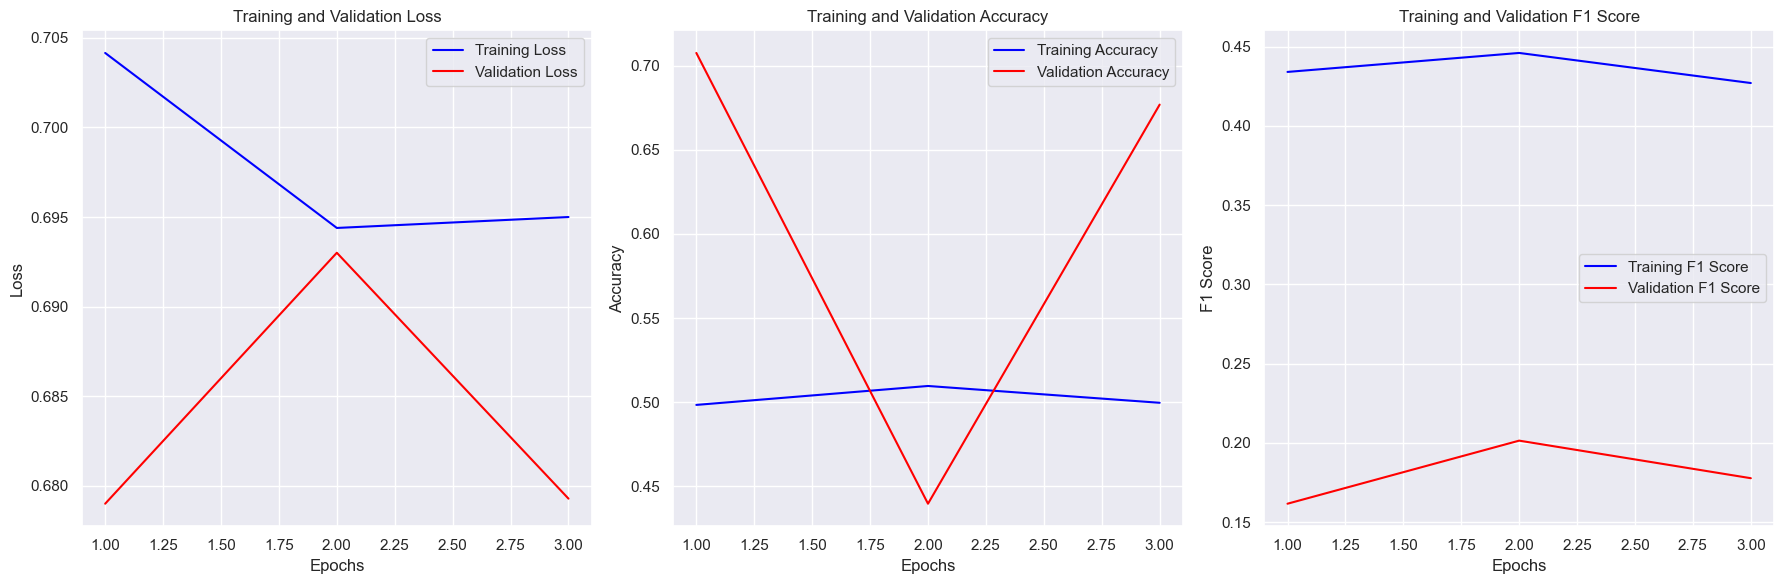

In [19]:
# Plotting the training progress
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(18, 6))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# F1 Score plot
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1s, label='Training F1 Score', color='blue')
plt.plot(epochs, val_f1s, label='Validation F1 Score', color='red')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

#### Load First Model

In [20]:
# Load the scripted model
model = torch.jit.load('../Models/best_model.pth')
model.to(device)
model.eval()

RecursiveScriptModule(
  original_name=DynamicANN
  (network): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=BatchNorm1d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Dropout)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=BatchNorm1d)
    (6): RecursiveScriptModule(original_name=ReLU)
    (7): RecursiveScriptModule(original_name=Dropout)
    (8): RecursiveScriptModule(original_name=Linear)
    (9): RecursiveScriptModule(original_name=BatchNorm1d)
    (10): RecursiveScriptModule(original_name=ReLU)
    (11): RecursiveScriptModule(original_name=Dropout)
    (12): RecursiveScriptModule(original_name=Linear)
    (13): RecursiveScriptModule(original_name=BatchNorm1d)
    (14): RecursiveScriptModule(original_name=ReLU)
    (15): RecursiveScriptModule(original_name=Dropout)
    (16): Recur

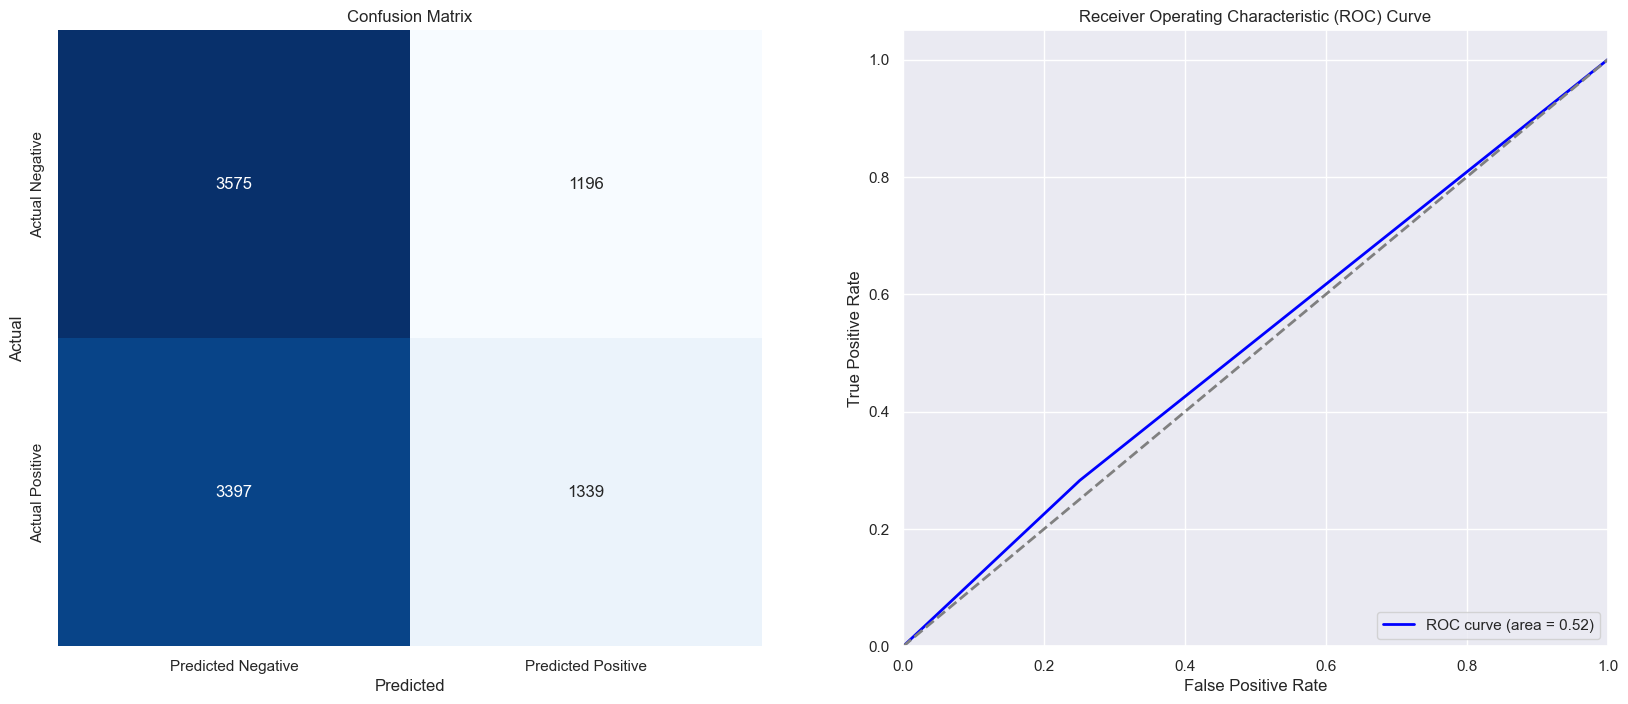

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,ANN,3 Epochs,"ANN - BalancedDataLoader - All Features - hidden_layers = [128, 256, 64, 16] & dropout_rate = 0.5 & use_batch_norm = True & L2: 1e-05",Training,0.516882,0.282728,0.368312,0.506654,0.528205,0.749319,0.516023


In [21]:
# initialize variables
Algorithm = 'ANN'
Desc = f'ANN - BalancedDataLoader - All Features - hidden_layers = {hidden_layers} & dropout_rate = {dropout_rate} & use_batch_norm = {use_batch_norm} & L2: {weight_decay}'
Model = f'{epoch+1} Epochs'
Type = 'Training'

# display
df_classification = ClassificationMatricANN(Algorithm, Model, Desc, Type, model, loader='train_loader')
df_classification

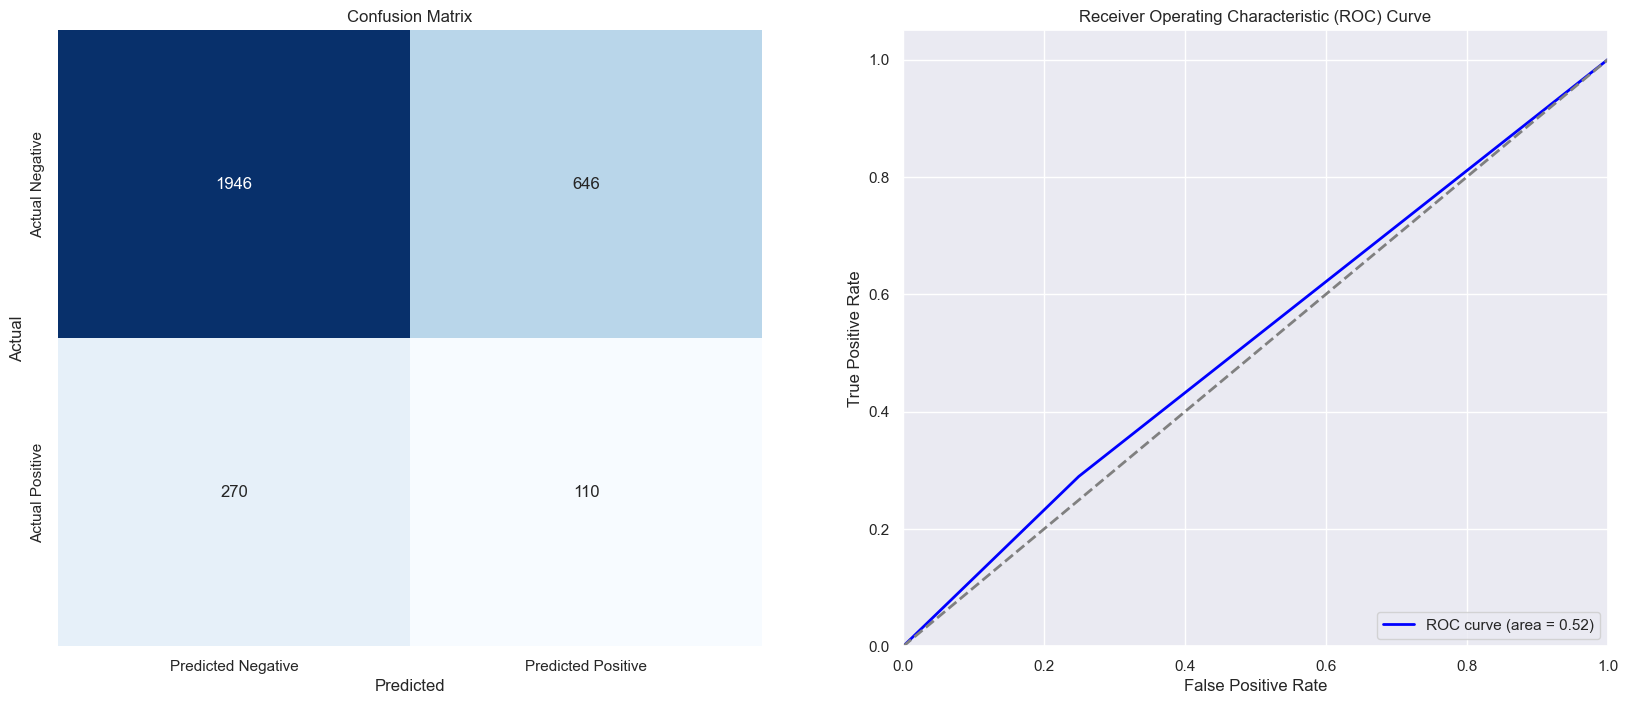

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,ANN,3 Epochs,"ANN - BalancedDataLoader - All Features - hidden_layers = [128, 256, 64, 16] & dropout_rate = 0.5 & use_batch_norm = True & L2: 1e-05",Training,0.516882,0.282728,0.368312,0.506654,0.528205,0.749319,0.516023
1,ANN,3 Epochs,"ANN - BalancedDataLoader - All Features - hidden_layers = [128, 256, 64, 16] & dropout_rate = 0.5 & use_batch_norm = True & L2: 1e-05",Validation,0.691790,0.289474,0.193662,0.132967,0.145503,0.750772,0.520123


In [22]:
# initialize variables
Algorithm = 'ANN'
Desc = f'ANN - BalancedDataLoader - All Features - hidden_layers = {hidden_layers} & dropout_rate = {dropout_rate} & use_batch_norm = {use_batch_norm} & L2: {weight_decay}'
Model = f'{epoch+1} Epochs'
Type = 'Validation'

# display
df_classification = ClassificationMatricANN(Algorithm, Model, Desc, Type, model, 'test_loader', df_classification)
df_classification